In [71]:
#Import Cell

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, fbeta_score
import os
import random

In [81]:
# Custom dataset class
class XRayDataset():
    def __init__(self, path):
        self.trainData = [] 
        self.validationData = []
        self.validationTestData = []
        self.testData = []

        normal_train_path = os.path.join(path, "train/NORMAL")
        for filename in os.listdir(normal_train_path):
            image_path = os.path.join(normal_train_path, filename)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image = Image.open(image_path)
                image = cropToSquare(image)
                transform(image)
                self.trainData.append({"image":image, "label": 0 })

        pneumonia_train_path = os.path.join(path, "train/PNEUMONIA")
        for filename in os.listdir(pneumonia_train_path):
            image_path = os.path.join(pneumonia_train_path, filename)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image = Image.open(image_path)
                image = cropToSquare(image)
                transform(image)
                if "bacteria" in str(filename):
                    self.trainData.append({"image":image, "label": 1 })
                else:
                    self.trainData.append({"image":image, "label": 2 })

        #Validation set load
        normal_val_path = os.path.join(path, "val/NORMAL")
        for filename in os.listdir(normal_val_path):
            image_path = os.path.join(normal_val_path, filename)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image = Image.open(image_path)
                image = cropToSquare(image)
                transform(image)
                self.trainData.append({"image":image, "label": 0 })

        pneumonia_val_path = os.path.join(path, "val/PNEUMONIA")
        for filename in os.listdir(pneumonia_val_path):
            image_path = os.path.join(pneumonia_val_path, filename)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image = Image.open(image_path)
                image = cropToSquare(image)
                transform(image)
                if "bacteria" in filename:
                    self.trainData.append({"image":image, "label": 1 })
                else:
                    self.trainData.append({"image":image, "label": 2 })

        #Testing set load
        normal_test_path = os.path.join(path, "test/NORMAL")
        for filename in os.listdir(normal_test_path):
            image_path = os.path.join(normal_test_path, filename)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image = Image.open(image_path)
                image = cropToSquare(image)
                transform(image)
                self.testData.append({"image":image, "label": 0 })

        pneumonia_test_path = os.path.join(path, "test/PNEUMONIA")
        for filename in os.listdir(pneumonia_test_path):
            image_path = os.path.join(pneumonia_test_path, filename)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image = Image.open(image_path)
                image = cropToSquare(image)
                transform(image)
                if "bacteria" in filename:
                    self.testData.append({"image":image, "label": 1 })
                else:
                    self.testData.append({"image":image, "label": 2 })

        random.shuffle(self.trainData)
        random.shuffle(self.testData)

        n = len(self.trainData)
        trainEnd = int(0.8 * n)
        valEnd = int(0.9 * n)
        
        # Split the list
        self.validationData = self.trainData[trainEnd:valEnd]
        self.validationTestData = self.trainData[valEnd:]
        self.trainData = self.trainData[:trainEnd]
       
    def checkDistribution(self):
        # Training
        bacteria = 0
        virus = 0
        normal = 0
        for i in test.trainData:
            if i["label"] == 1:
                bacteria += 1
            elif i["label"] == 2:
                virus += 1
            else:
                normal += 1
        print("Normal in training: ", normal)
        print("Bacteria in training: ", bacteria)
        print("Virus in training: ", virus)

        # Validation
        bacteria = 0
        virus = 0
        normal = 0
        for i in test.validationData:
            if i["label"] == 1:
                bacteria += 1
            elif i["label"] == 2:
                virus += 1
            else:
                normal += 1
        print("Normal in validation: ", normal)
        print("Bacteria in validation: ", bacteria)
        print("Virus in validation: ", virus)

        # Validation test
        bacteria = 0
        virus = 0
        normal = 0
        for i in test.validationTestData:
            if i["label"] == 1:
                bacteria += 1
            elif i["label"] == 2:
                virus += 1
            else:
                normal += 1
        print("Normal in validation test: ", normal)
        print("Bacteria in validation test: ", bacteria)
        print("Virus in validation test: ", virus)

        # Test
        bacteria = 0
        virus = 0
        normal = 0
        for i in test.testData:
            if i["label"] == 1:
                bacteria += 1
            elif i["label"] == 2:
                virus += 1
            else:
                normal += 1
        print("Normal in test: ", normal)
        print("Bacteria in test: ", bacteria)
        print("Virus in test: ", virus)

    def printOneImage(self):
        # Resized
        print(len(self.trainData))
        plt.imshow(self.trainData[0]["image"], cmap='gray')
        plt.axis('off')


# CNN Model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512) # Adjust input size based on image resizing
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8) # Adjust input size based on image resizing
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def cropToSquare(Img):
    width, height = Img.size 
    min_side = min(width, height)

    left = (width - min_side) // 2
    top = (height - min_side) // 2
    right = left + min_side
    bottom = top + min_side
    return Img.crop((left, top, right, bottom))

# Hyperparameters
image_size = (512, 512) # Resize images
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Transformations (Resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize(image_size, interpolation = transforms.functional.InterpolationMode.LANCZOS),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1,1]
])


Training

In [79]:
dataset = XRayDataset("Project_Data/chest_xray")

dataset.checkDistribution()

Normal in training:  1065
Bacteria in training:  2043
Virus in training:  1077
Normal in validation:  143
Bacteria in validation:  244
Virus in validation:  136
Normal in validation test:  141
Bacteria in validation test:  251
Virus in validation test:  132
Normal in test:  234
Bacteria in test:  242
Virus in test:  148


In [ ]:
# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()

    for data in dataset.trainData:
        image, label = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
    
    # for images, labels in train_loader:
    #   images, labels = images.to(device), labels.to(device)
    #   optimizer.zero_grad()
    #   outputs = model(images)
    #   loss = criterion(outputs, labels)
    #   loss.backward()
    #   optimizer.step()

    # Validation loop
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data in dataset.validationData:
            image, label = data["image"].to(device), data["label"].to(device)
            output = model(image)
            _, predicted = torch.max(output.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        # for images, labels in val_loader:
        #     images, labels = images.to(device), labels.to(device)
        #     outputs = model(images)
        #     _, predicted = torch.max(outputs.data, 1)
        #     all_predictions.extend(predicted.cpu().numpy())
        #     all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    f2 = fbeta_score(all_labels, all_predictions, average='weighted', beta = 2)
    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")





Testing different image resizing techniques

<class 'PIL.JpegImagePlugin.JpegImageFile'>


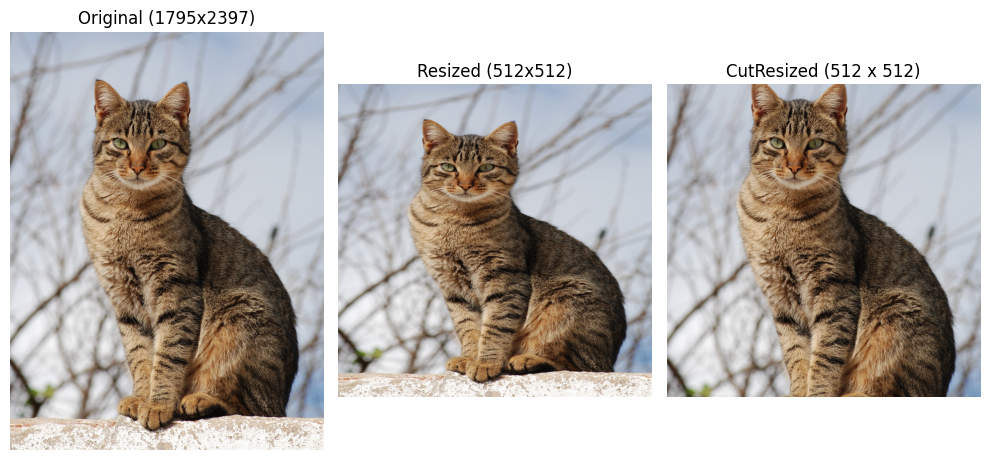

In [80]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = "Project_Data/Cat.jpg"  # Replace with your image path
original = Image.open(image_path)

print(type(original))
# Resize to 512x512

cutResize = cropToSquare(original)

resized = original.resize((512, 512), Image.LANCZOS)
cutResized = cutResize.resize((512, 512), Image.LANCZOS)

# Plot original and resized image
plt.figure(figsize=(10, 5))

# Original
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title(f"Original ({original.size[0]}x{original.size[1]})")
plt.axis('off')

# Resized
plt.subplot(1, 3, 2)
plt.imshow(resized)
plt.title("Resized (512x512)")
plt.axis('off')

# CutResized
plt.subplot(1, 3, 3)
plt.imshow(cutResized)
plt.title(f"CutResized ({cutResized.size[0]} x {cutResized.size[1]})")
plt.axis('off')

plt.tight_layout()
plt.show()